# KNN Classification of Weather

## Introduction

Weather warnings are important forecasts because they are used to protect life and property. Especially in Seattle, a city that rains often, forecasts are made based on temperature, precipitation to help determine future climate expectations. These forecasts help business and farmers plan for power usage, irrigation and protection and also help people plan activities and dress for the weather accordingly. 
 
This model aims to answer the question: **how accurately can we classify weather using daily precipitation, wind speed and average temperature as predictors**? Our dataset (source: https://www.kaggle.com/ananthr1/weather-prediction) contains the date, precipitation, maximum and minimum temperatures, wind speed and their corresponding weather classifications (drizzle, rain, sun, snow, fog). These observations have been reported daily in Seattle from the beginning of 2012 to the end of 2015. By understanding the relationships among these variables, it helps meteorologists better predict the weather for the public. 
 
The data set we obtained from Kaggle contains daily observations of weather in Seattle, Washington between 2012 to 2015. The set of variables per observation in this data set is:
- date: the date of the observation
- precipitation: the amount of precipitation in any form (cm)
- temp_max: the maximum temperature (Celsius)
- temp_min: the minimum temperature (Celsius)
- wind: the wind speed (mph)
- weather: the type of weather (drizzle, rain, sun, snow, fog)
Note that the original data set did not provide units, so we made a reasonable guess for each variable. (For example, 10°C is more reasonable than 10°F for temperature)


## Preliminary Exploratory Data Analysis

In [30]:
# Run this code to set up the notebook
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [32]:
# Read the data into R (downloaded as csv from https://www.kaggle.com/ananthr1/weather-prediction)
weather_data <- read_csv("weather.csv") %>%
    mutate(weather = as_factor(weather),
           temp_avg = (temp_max + temp_min)/2)
weather_data

Parsed with column specification:
cols(
  date = col_date(format = ""),
  precipitation = col_double(),
  temp_max = col_double(),
  temp_min = col_double(),
  wind = col_double(),
  weather = col_character()
)



date,precipitation,temp_max,temp_min,wind,weather,temp_avg
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90
2012-01-02,10.9,10.6,2.8,4.5,rain,6.70
2012-01-03,0.8,11.7,7.2,2.3,rain,9.45
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog,3.90
2015-12-30,0,5.6,-1.0,3.4,sun,2.30
2015-12-31,0,5.6,-2.1,3.5,sun,1.75


In [59]:
# Count the number of observations for each weather type
weather_data_count <- weather_data %>%
    group_by(weather) %>%
    summarize(n = n())
weather_data_count
# Calculate the means of predictor variables to be used in the analysis
# TODO: change to human-readable names
weather_predictor_means <- weather_data %>%
    select(precipitation, temp_avg, wind) %>%
    map(mean)
weather_predictor_means

`summarise()` ungrouping output (override with `.groups` argument)



weather,n
<fct>,<int>
drizzle,53
rain,641
sun,640
snow,26
fog,101


$precipitation
[1] 3.029432

$temp_avg
[1] 12.33693

$wind
[1] 3.241136

In [39]:
# Scale the weather data
weather_data_scaled <- weather_data %>%
    mutate(scaled_precipitation = scale(precipitation, center = TRUE),
          scaled_wind = scale(wind, center = TRUE),
          scaled_temp_avg = scale(temp_avg, center = TRUE))
weather_data_scaled

date,precipitation,temp_max,temp_min,wind,weather,temp_avg,scaled_precipitation,scaled_wind,scaled_temp_avg
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2012-01-01,0.0,12.8,5.0,4.7,drizzle,8.90,-0.4534946,1.0146323,-0.5730072
2012-01-02,10.9,10.6,2.8,4.5,rain,6.70,1.1781945,0.8755334,-0.9397930
2012-01-03,0.8,11.7,7.2,2.3,rain,9.45,-0.3337376,-0.6545554,-0.4813108
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog,3.90,-0.4534946,-0.4459070,-1.406611
2015-12-30,0,5.6,-1.0,3.4,sun,2.30,-0.4534946,0.1104890,-1.673365
2015-12-31,0,5.6,-2.1,3.5,sun,1.75,-0.4534946,0.1800384,-1.765061


In [46]:
# Calculate the range of measured precipitation (scaled)
max(weather_data_scaled$scaled_precipitation)
min(weather_data_scaled$scaled_precipitation)

[1] 7.914525

[1] -0.4534946

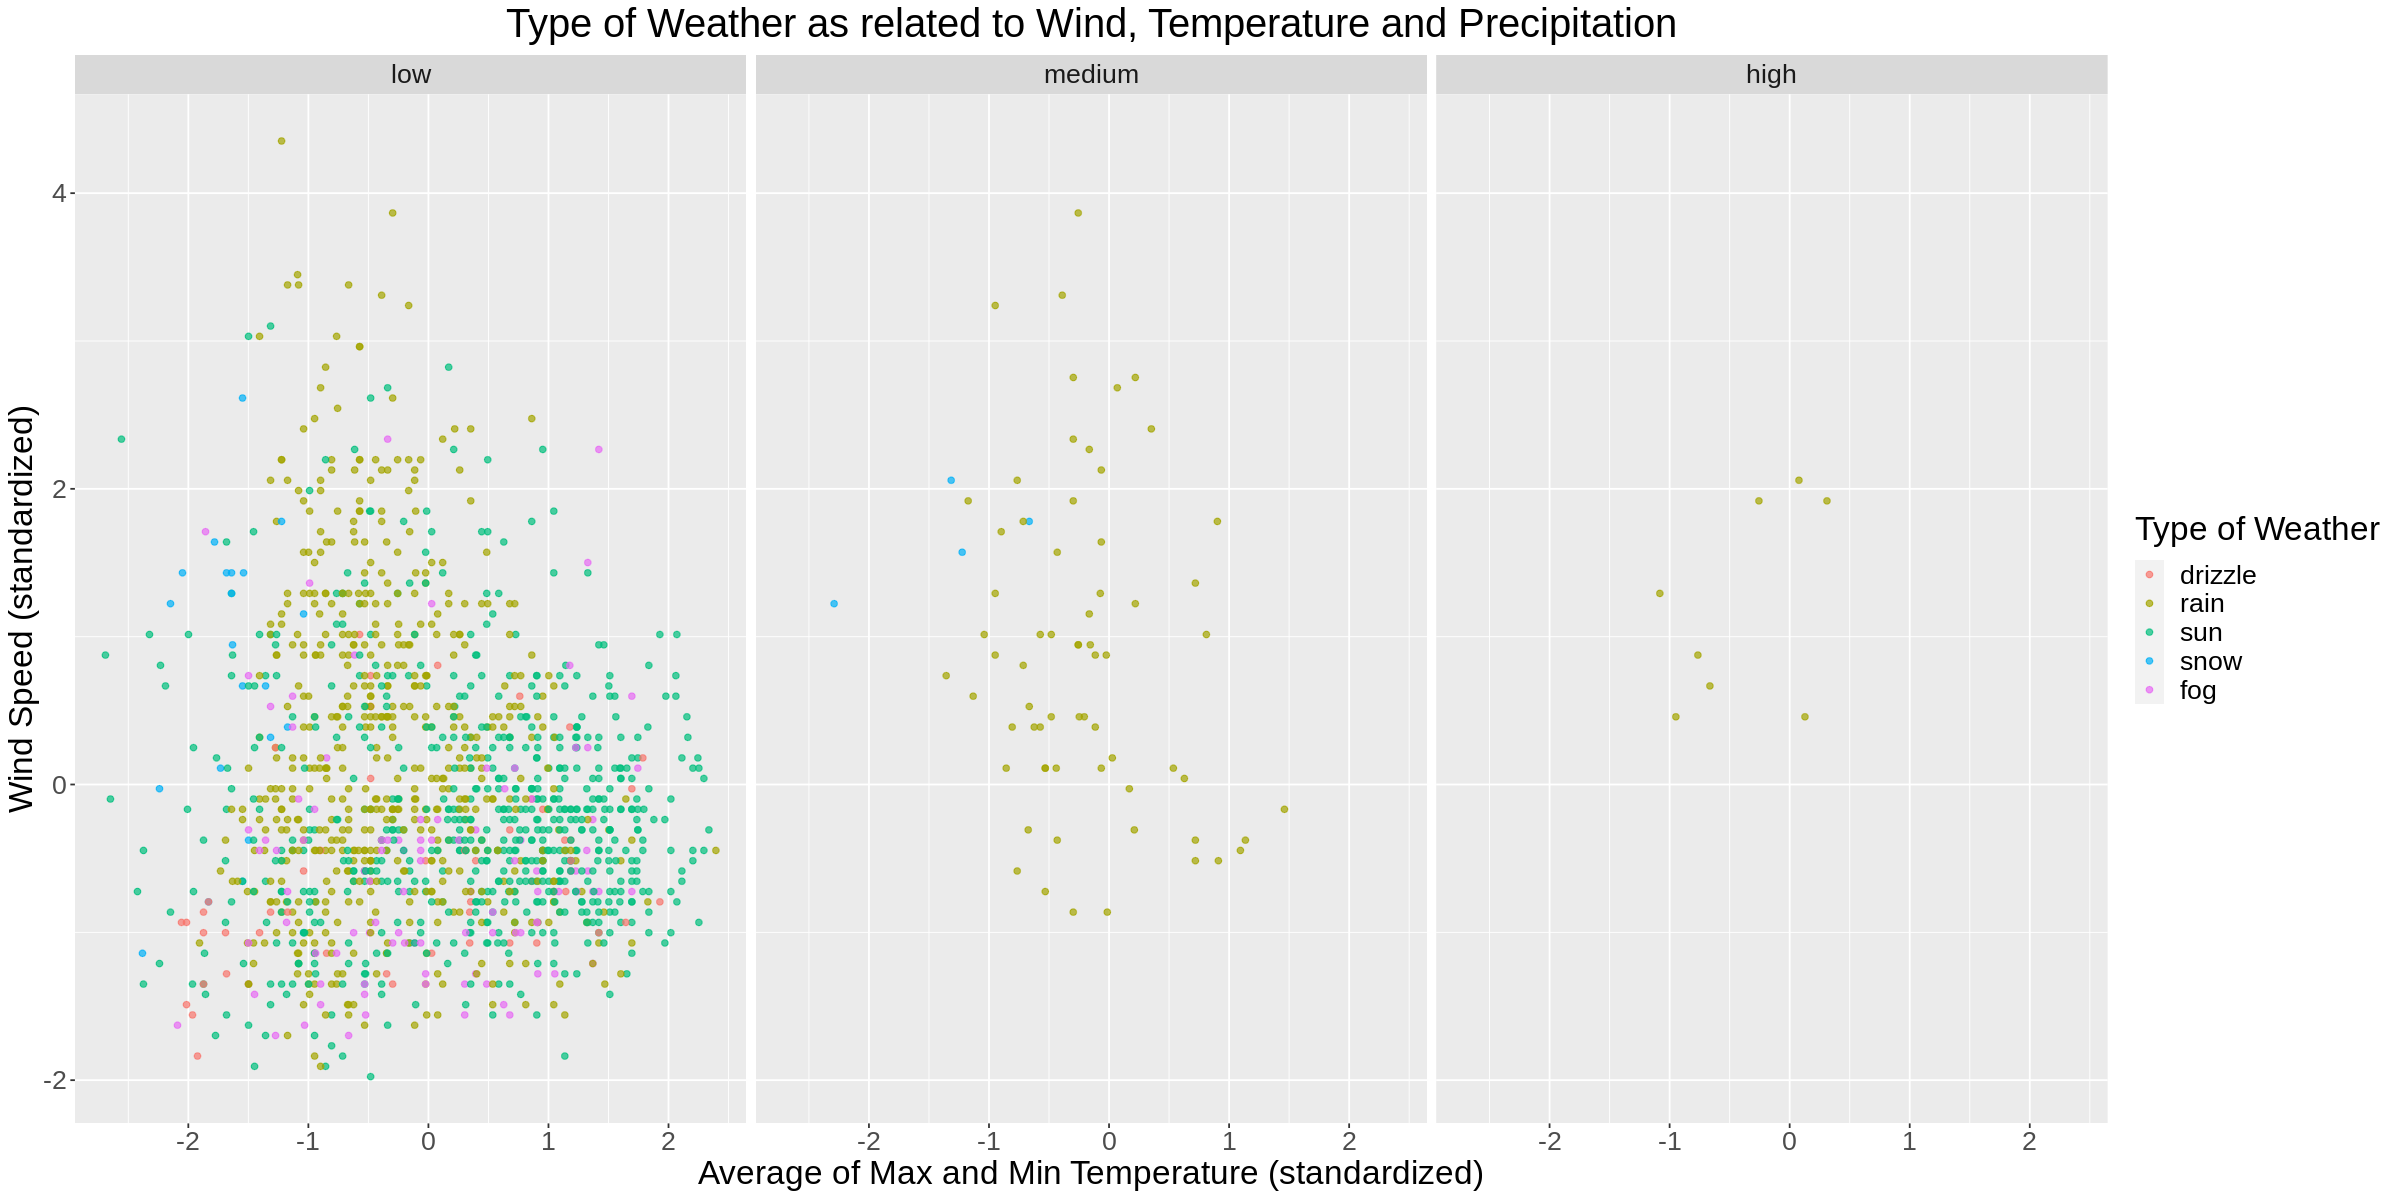

In [57]:
# Since precipitation values lie aproximately between [-1,8], we split the continuous variable into 3 categories
weather_data_scaled <- weather_data_scaled %>% 
    mutate(precipitation_category = cut(scaled_precipitation, breaks = c(-1, 2, 5, 8), labels = c("low", "medium", "high")))
# Create a plot of wind vs average temperature for each precipitation category, and use color to differentiate the type of weather
weather_plot <- weather_data_scaled %>%
    ggplot(aes(x = scaled_temp_avg, y = scaled_wind, color = weather)) +
    geom_point(alpha = 0.7) +
    facet_wrap(~precipitation_category) +
    labs(title = "Type of Weather as related to Wind, Temperature and Precipitation", color = "Type of Weather") +
    xlab("Average of Max and Min Temperature (standardized)") + 
    ylab("Wind Speed (standardized)") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
# Set an appropriate size for the plot
options(repr.plot.width = 20, repr.plot.height = 10)
weather_plot

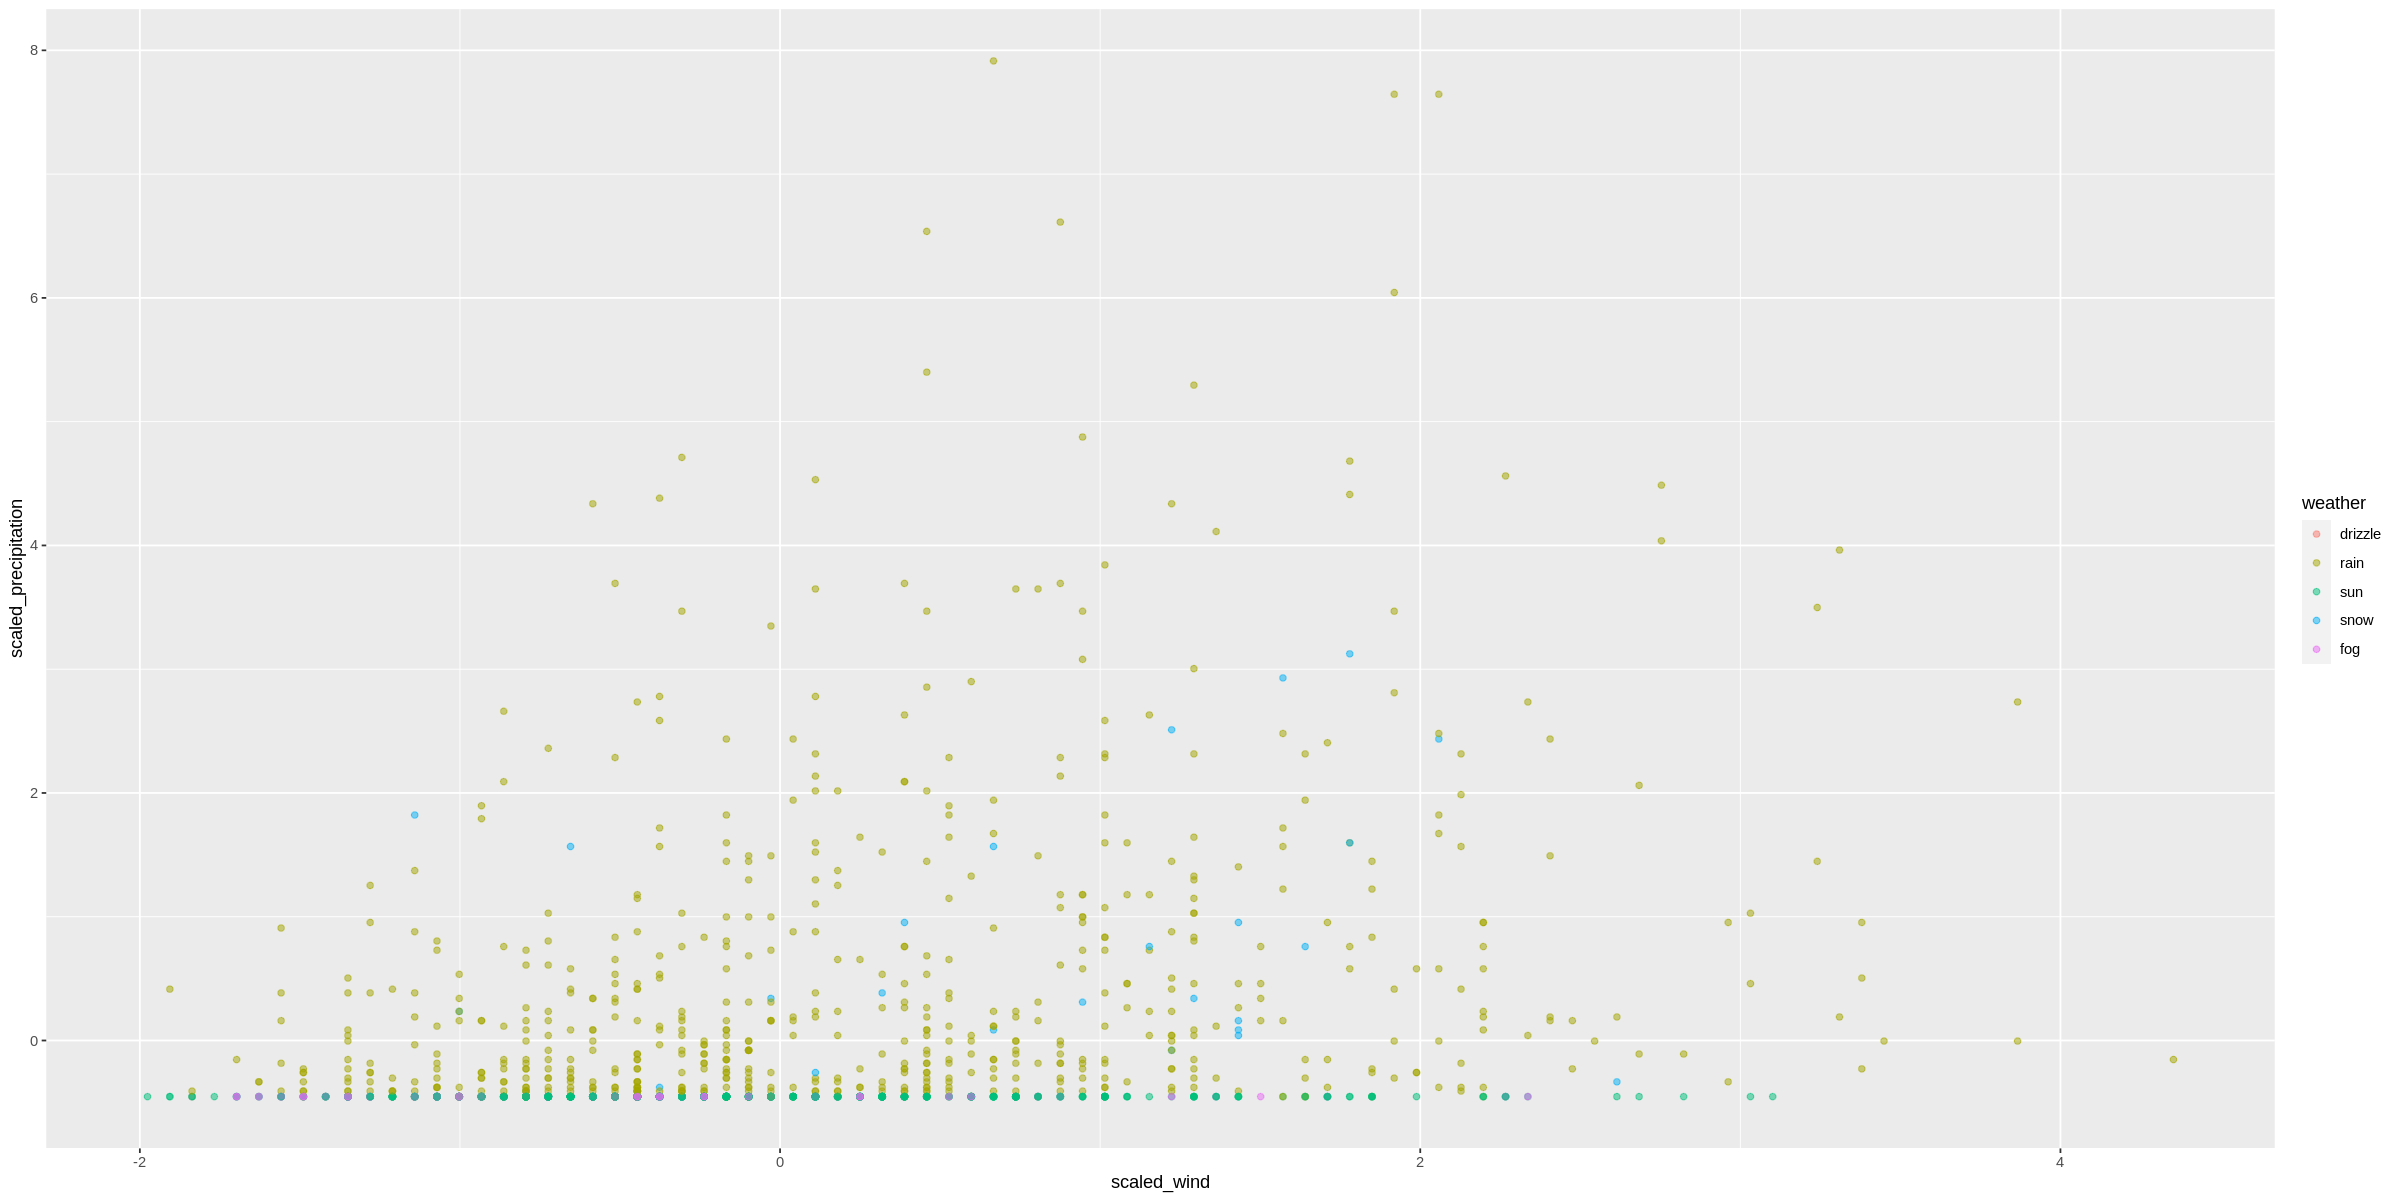

In [63]:
plot <- weather_data_scaled %>% 
    ggplot(aes(x = scaled_wind, y = scaled_precipitation)) +
    geom_point(aes(color = weather), alpha = 0.5)
plot

## Methods

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results


- note the imbalance in number of observations of each class of weather
- cross-validation to help us find k value that gives higher accuracy
- predict using wind, average temperature, precipitation

- b

## Expected Outcomes and Significance

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?